In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import cv2
import numpy as np
import SimpleITK as sikt
from PIL import Image

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
image_path = '../data/ID_c9d6fdc6_ID_7f09be285d.png'
label_path = '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.png'

In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 12

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

def print_info(img, label):
    print(f"Image shape: {img.shape}, Label shape: {label.shape}")

In [4]:
image = cv2.imread(image_path)
label = np.asarray(Image.open(label_path))

## RandomCrop

`RandomCrop` 的主要作用是：

> 从输入图像中 **随机选择一个位置**，并在该位置上裁剪出一个给定大小的区域（即子图），用于替代原始图像。

### 工作流程如下：

1.  输入一张图像，设其尺寸为 `H x W`。

2.  给定目标裁剪尺寸 `height x width`。

3.  在图像上 **随机选择一个左上角坐标 (x, y)**，使得从该点开始裁剪不会超出图像边界。

4.  输出裁剪后的区域图像及其对应的标签（如 bounding boxes, masks, keypoints 等，也会自动裁剪/调整）。

### 使用场景 

-   对大尺寸图像进行小区域采样，减少训练内存负担

-   一张图像可生成多个不同视角的训练样本

-   模拟目标部分缺失，增强鲁棒性

-   可以防止模型对背景区域过拟合，引导其关注局部区域

### 参数解析 

| 参数名          | 类型                           | 默认值                | 说明                                                         |
| --------------- | ------------------------------ | --------------------- | ------------------------------------------------------------ |
| `height`        | `int`                          | 必填                  | 裁剪区域的目标高度（像素）                                   |
| `width`         | `int`                          | 必填                  | 裁剪区域的目标宽度（像素）                                   |
| `pad_if_needed` | `bool`                         | `False`               | 若图像尺寸小于裁剪尺寸，是否进行填充。设为 `True` 可防止报错 |
| `border_mode`   | `int (cv2 flag)`               | `cv2.BORDER_CONSTANT` | 使用哪种 OpenCV 边界模式填充图像，如常量边界、镜像边界等     |
| `fill`          | `float` 或 `tuple[float, ...]` | `0`                   | 填充图像边缘的像素值（若 `border_mode = BORDER_CONSTANT`）   |
| `fill_mask`     | `float` 或 `tuple[float, ...]` | `0`                   | 填充 mask 边缘的像素值（若 `border_mode = BORDER_CONSTANT`） |
| `pad_position`  | `str`（枚举类型）              | `'center'`            | 填充时裁剪区域在原图中的相对位置，可选值：`center`, `top_left`, `top_right`, `bottom_left`, `bottom_right`, `random` |
| `p`             | `float`                        | `1.0`                 | 应用该变换的概率，范围为 `[0.0, 1.0]`                        |

Image shape: (400, 400, 3), Label shape: (400, 400)


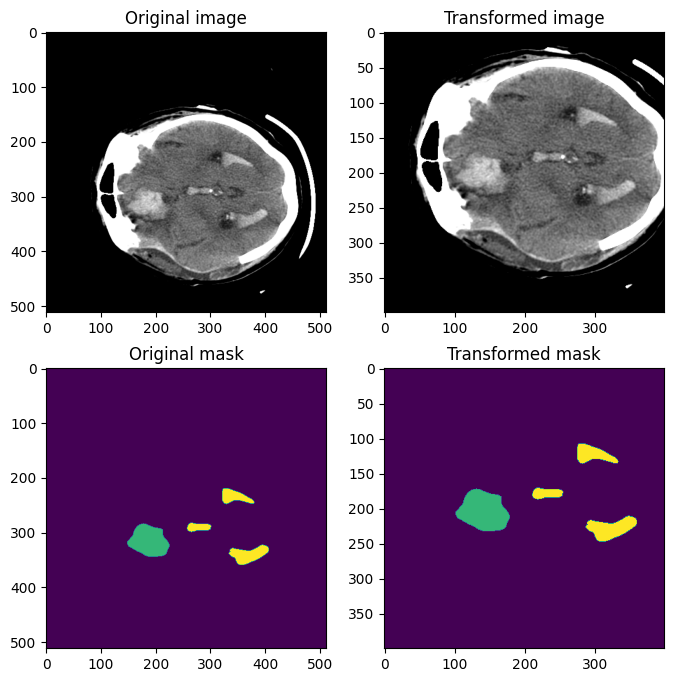

In [5]:
transform = A.Compose([
    A.RandomCrop(height=400, width=400, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## CenterCrop

`CenterCrop` 主要用于将图像从中心裁剪为指定大小。它广泛应用于图像分类、目标检测、语义分割等任务中，特别是在模型训练前统一图像尺寸或移除边缘噪声时非常有用。

### 使用场景 

-   **去除图像边缘噪声**：有些图像边缘可能包含拍摄错误、边缘模糊等问题，使用 `CenterCrop` 可以更关注中心目标。

### 参数解析 

| 参数名          | 类型                           | 说明                                                         | 默认值                |
| --------------- | ------------------------------ | ------------------------------------------------------------ | --------------------- |
| `height`        | `int`                          | 裁剪区域的高度，必须大于 0                                   | 无（必填）            |
| `width`         | `int`                          | 裁剪区域的宽度，必须大于 0                                   | 无（必填）            |
| `pad_if_needed` | `bool`                         | 若裁剪区域大于图像尺寸时，是否自动填充图像                   | `False`               |
| `border_mode`   | `int (OpenCV flag)`            | 填充时使用的边界模式（如 `cv2.BORDER_CONSTANT`, `cv2.BORDER_REFLECT` 等） | `cv2.BORDER_CONSTANT` |
| `fill`          | `float` 或 `tuple[float, ...]` | 若使用 `cv2.BORDER_CONSTANT` 进行填充，图像的填充值          | `0`                   |
| `fill_mask`     | `float` 或 `tuple[float, ...]` | 若使用 `cv2.BORDER_CONSTANT` 进行填充，mask 的填充值         | `0`                   |
| `pad_position`  | `str (Literal)`                | 填充区域的位置，可选：`'center'`, `'top_left'`, `'top_right'`, `'bottom_left'`, `'bottom_right'`, `'random'` | `'center'`            |
| `p`             | `float`                        | 应用该变换的概率，范围 `[0, 1]`                              | `1.0`                 |

Image shape: (400, 400, 3), Label shape: (400, 400)


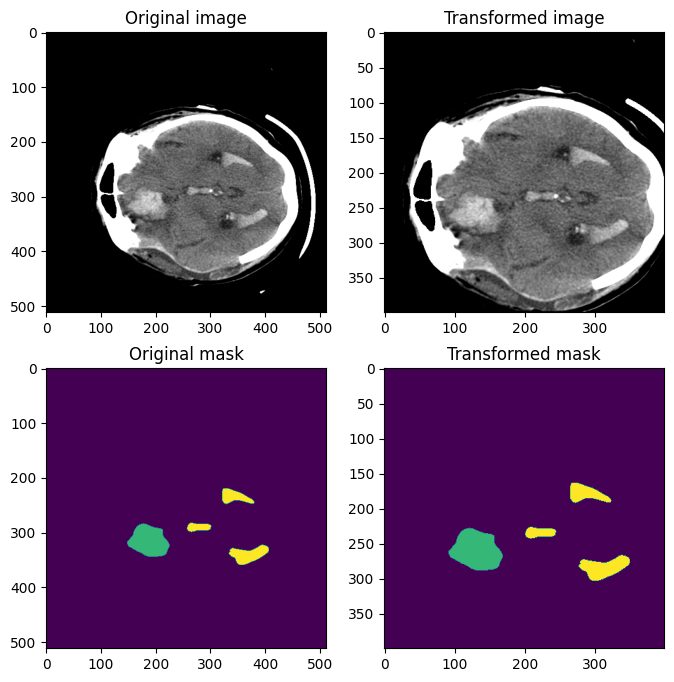

In [6]:
transform = A.Compose([
    A.CenterCrop(height=400, width=400, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## CropNonEmptyMaskIfExists

`CropNonEmptyMaskIfExists`主要用于语义分割和实例分割任务中，它可以**根据 mask 中的前景区域进行裁剪**，确保裁剪后的图像包含有标注的目标。

`CropNonEmptyMaskIfExists` 的原理就是：

1.  **检查是否有 mask**（即非空的 mask）。

2.  **在 mask 的前景区域周围随机选择一个裁剪位置**，裁剪的窗口尺寸由参数指定。

3.  如果找不到非空区域（例如全部是背景），则会随机裁剪图像（作为 fallback 机制）。

4.  裁剪后返回图像、mask，以及其他附加信息（如 bboxes、keypoints）的一致裁剪结果。

### 使用场景 

-   **图像分割任务**（语义分割 / 实例分割 / 多标签分割）

-   希望增强过程中不要裁掉前景目标（如医学图像中的病灶、自动驾驶中的车辆等）

-   数据集中前景区域小、稀疏，随机裁剪容易丢失前景的情况

### 参数解析 

| 参数名            | 类型        | 是否必需 | 默认值 | 说明                                                         |
| ----------------- | ----------- | -------- | ------ | ------------------------------------------------------------ |
| `height`          | `int`       | 是       | 无     | 裁剪区域的垂直尺寸（单位：像素），必须 > 0                   |
| `width`           | `int`       | 是       | 无     | 裁剪区域的水平尺寸（单位：像素），必须 > 0                   |
| `ignore_values`   | `list[int]` | 否       | `None` | 忽略 mask 中的像素值。默认情况下 `0` 总是被忽略。例如：如果背景值为 `5`，则设置为 `[5]` |
| `ignore_channels` | `list[int]` | 否       | `None` | 忽略 mask 中的某些通道（适用于多通道 mask）。例如：如果背景位于第一个通道，则设为 `[0]` |
| `p`               | `float`     | 否       | `1.0`  | 应用该变换的概率                                             |

Image shape: (400, 400, 3), Label shape: (400, 400)


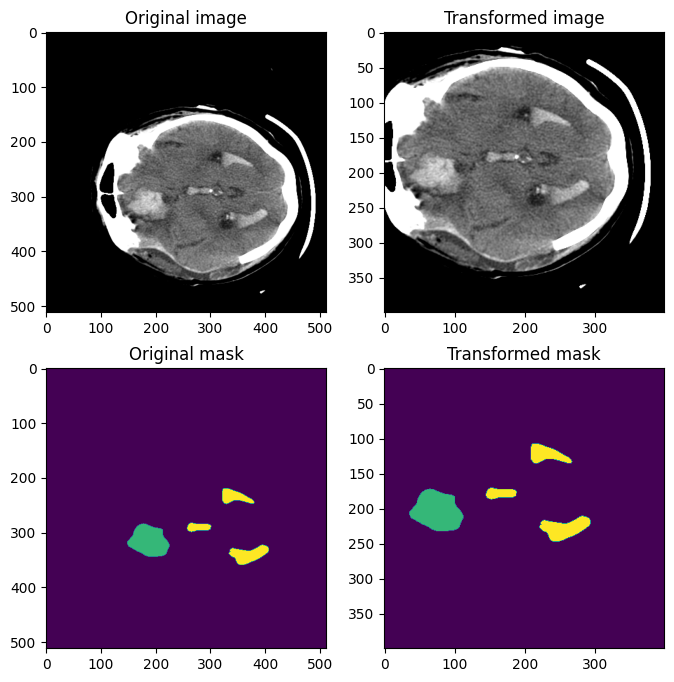

In [7]:
transform = A.Compose([
     A.CropNonEmptyMaskIfExists(height=400, width=400, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## RandomSizedCrop

`RandomSizedCrop` 主要作用是**随机裁剪图像的一部分，并调整为指定的目标尺寸**，用于提升模型对不同图像尺度和结构的鲁棒性。

`CropNonEmptyMaskIfExists` 的原理就是：

1.  **检查是否有 mask**（即非空的 mask）。

2.  **在 mask 的前景区域周围随机选择一个裁剪位置**，裁剪的窗口尺寸由参数指定。

3.  如果找不到非空区域（例如全部是背景），则会随机裁剪图像（作为 fallback 机制）。

4.  裁剪后返回图像、mask，以及其他附加信息（如 bboxes、keypoints）的一致裁剪结果。

### 使用场景 

-   **目标检测、图像分类、语义分割**：增强模型对局部区域、不同尺度下目标的识别能力；

-   **小目标任务**：通过裁剪，模拟远距离、小目标出现的情况；

-   **数据不平衡或背景单一时**：随机裁剪可引入多样性，防止模型过拟合；

-   **需要统一输入尺寸的神经网络**：如 CNN，裁剪后统一缩放满足尺寸要求。

### 参数解析 

| 参数名               | 类型                                       | 说明                                                         | 默认值              |
| -------------------- | ------------------------------------------ | ------------------------------------------------------------ | ------------------- |
| `min_max_height`     | `tuple[int, int]`                          | 裁剪区域的最小和最大高度（单位：像素）                       | 无（必填）          |
| `size`               | `tuple[int, int]`                          | 裁剪后图像输出的目标尺寸，格式为 `(height, width)`           | 无（必填）          |
| `w2h_ratio`          | `float`                                    | 裁剪区域的宽高比（宽度 / 高度）                              | `1.0`               |
| `interpolation`      | `int`（OpenCV 插值常量）                   | 图像缩放时的插值方法，可选：`cv2.INTER_NEAREST`, `cv2.INTER_LINEAR`, `cv2.INTER_CUBIC`, `cv2.INTER_AREA`, `cv2.INTER_LANCZOS4` | `cv2.INTER_LINEAR`  |
| `mask_interpolation` | `int`（OpenCV 插值常量）                   | mask 缩放时的插值方法（同上）                                | `cv2.INTER_NEAREST` |
| `area_for_downscale` | `None` 或 `Literal["image", "image_mask"]` | 是否自动使用 `INTER_AREA` 进行下采样：<br/>• `None`: 不自动切换插值方法<br/>• `"image"`: 图像下采样使用 `INTER_AREA`<br/>• `"image_mask"`: 图像和 mask 下采样都用 `INTER_AREA` | `None`              |
| `p`                  | `float`                                    | 应用该变换的概率                                             | `1.0`               |

Image shape: (224, 224, 3), Label shape: (224, 224)


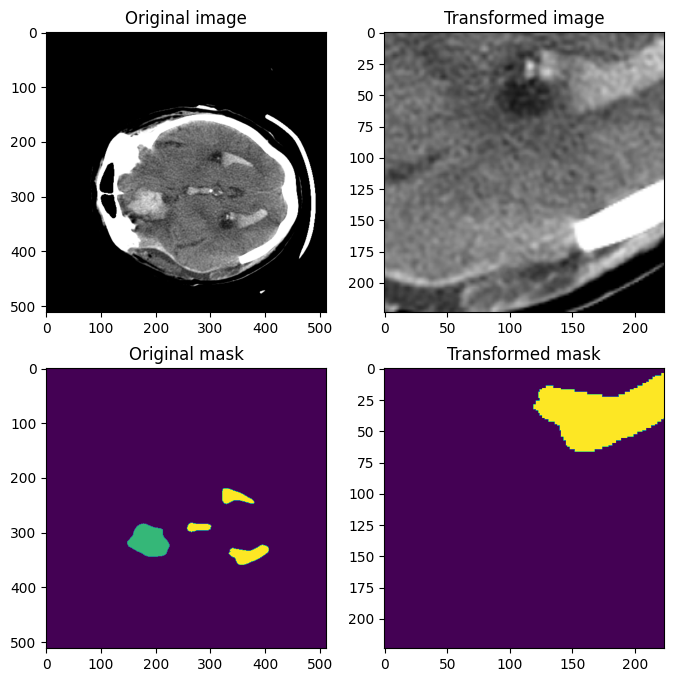

In [8]:
transform = A.Compose([
    A.RandomSizedCrop(min_max_height=(100, 200), height=400, width=224, p=1.0),
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## RandomResizedCrop

`RandomResizedCrop` 主要用于随机裁剪并缩放图像，广泛应用于图像分类、目标检测等任务的数据增强中。

`RandomResizedCrop` 操作包括两个步骤：

1.  **随机裁剪**：在原图上随机选取一个子区域，面积和长宽比在设定范围内；

2.  **缩放变换**：将这个裁剪得到的子区域缩放到固定的目标尺寸（`height`, `width`）。

### 使用场景 

-   **目标检测、图像分类、语义分割**：增强模型对局部区域、不同尺度下目标的识别能力；

-   **小目标任务**：通过裁剪，模拟远距离、小目标出现的情况；

-   **数据不平衡或背景单一时**：随机裁剪可引入多样性，防止模型过拟合；

-   **需要统一输入尺寸的神经网络**：如 CNN，裁剪后统一缩放满足尺寸要求。

### 参数解析 

| 参数名               | 类型                                | 默认值              | 说明                                                         |
| -------------------- | ----------------------------------- | ------------------- | ------------------------------------------------------------ |
| `size`               | `tuple[int, int]`                   | 必须指定            | 输出图像的目标尺寸，格式为 `(height, width)`，即裁剪+缩放后的结果尺寸。 |
| `scale`              | `tuple[float, float]`               | `(0.08, 1.0)`       | 裁剪区域相对于原图面积的比例范围。例如 `(0.08, 1.0)` 表示裁剪区域占原图的 8% 到 100%。 |
| `ratio`              | `tuple[float, float]`               | `(0.75, 1.3333)`    | 裁剪区域的宽高比范围。支持如 3:4 到 4:3 之间的随机变化。     |
| `interpolation`      | OpenCV 插值标志                     | `cv2.INTER_LINEAR`  | 图像缩放时使用的插值方式。可选值包括：`cv2.INTER_NEAREST`, `cv2.INTER_LINEAR`, `cv2.INTER_CUBIC`, `cv2.INTER_AREA`, `cv2.INTER_LANCZOS4`。 |
| `mask_interpolation` | OpenCV 插值标志                     | `cv2.INTER_NEAREST` | 控制下采样时是否自动使用 `INTER_AREA` 插值：<br/>• `None`：始终使用指定插值<br/>• `"image"`：图像下采样使用 `INTER_AREA`<br/>• `"image_mask"`：图像和掩码下采样都使用 `INTER_AREA` |
| `area_for_downscale` | `None` / `"image"` / `"image_mask"` | `None`              | 控制下采样时是否自动使用 `INTER_AREA` 插值：                 |
| `p`                  | `float`                             | `1.0`               | 应用该增强的概率，取值范围 `[0, 1]`，默认总是应用。          |

Image shape: (400, 400, 3), Label shape: (400, 400)


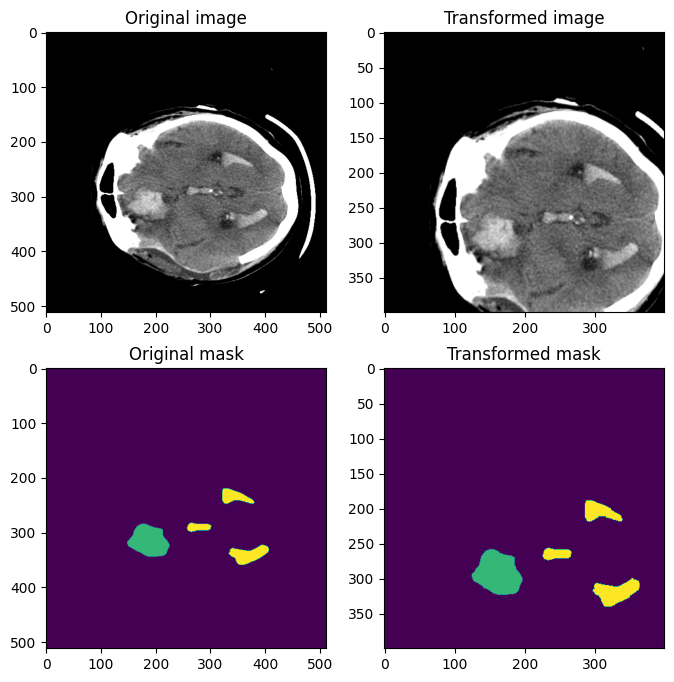

In [11]:
transform = A.Compose([
    A.RandomResizedCrop(height=400, width=400, scale=(0.5, 1.0), ratio=(0.75, 1.33), p=1.0),
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)